In [1]:
import os
import pandas as pd
import sys
import seaborn as sns
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
from sodapy import Socrata
from creds import getCensusAPI

path = os.path.abspath('')


In [2]:
#Load raw tract-wise data
fcc_path = path+'\\static-data\\cleaned_fcc_tracts.csv'

fcc_data = pd.read_csv(fcc_path)

fcc_data.drop(['Unnamed: 0'], axis=1, inplace=True)

fcc_data['state'] = fcc_data['state'].astype(str).str.zfill(2)
fcc_data['tract'] = fcc_data['tract'].astype(str).str.zfill(6)
fcc_data['county'] = fcc_data['county'].astype(str).str.zfill(3)

fcc_data.describe()

,Max Advertised Downstream Speed (mbps)
count,72987.000000
mean,838.148725
std,725.073403
min,2.000000
25%,940.000000
50%,1000.000000
75%,1000.000000
max,10000.000000


In [3]:
#Current threshold = 50mbps, further narrow down if needed, add labels to blocks
threshold = 50

fcc_data['Access'] = np.nan
fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] >= threshold] = 1
fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] < threshold] = 0

C:\Users\Jude\AppData\Local\Temp\ipykernel_1772\1412316767.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] >= threshold] = 1
C:\Users\Jude\AppData\Local\Temp\ipykernel_1772\1412316767.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcc_data['Access'][fcc_data['Max Advertised Downstream Speed (mbps)'] < threshold] = 0


In [4]:
print('{}% of census tracts lack access to sufficient internet speeds'.format(round((fcc_data['Access'].value_counts()[0]/len(fcc_data['Access']))*100,2)))

9.71% of census tracts lack access to sufficient internet speeds


https://api.census.gov/data/2020/acs/acs5/variables.html

In [64]:
cols = {
    #Population
    'B01003_001E':'Total',
    #Sex
    'B01001_002E':'Total Male',
    'B01001_026E':'Total Female',
    #Age
    'B01002_001E': 'Median Age',
    #Race 
    'B02001_002E': 'White',
    'B02001_003E': 'Black or African American',
    'B02001_004E': 'American Indian and Alaska Native',
    'B02001_005E': 'Asian',
    'B02001_006E': 'Native Hawaiian and Other Pacific Islander',
    'B02001_007E': 'Some other race',
    'B02001_008E': 'Two or more races',
    'B02001_009E': 'Two or more including some other race',
    'B02001_010E': 'Two or more excluding some other race, and three or more',
    'B03001_003E': 'Hispanic or Latino',
    #Citizenship
    'B05001_006E': 'Not a Citizen',
    #Birth
    'B05012_002E': 'Native',
    'B05012_003E': 'Foreign Born',
    #English and language proficiency
    'B06007_002E': 'Speak only English',
    'B06007_003E': 'Speak Spanish',
    'B06007_004E': 'Speak Spanish, English very well',
    'B06007_005E': 'Speak Spanish, English less than very well',
    'B06007_006E': 'Speak other languages',
    'B06007_007E': 'Speak other language, English very well',
    'B06007_008E': 'Speak other language, English less than very well',
    #Individual income
    'B06010_002E': 'No individual income (12mo)',
    'B06010_003E': 'With individual income (12mo)',
    'B06010_004E': 'Less than 10000 individual income (12mo)',
    'B06010_005E': '10000 - 14999 individual income (12mo)',
    'B06010_006E': '15000 - 24999 individual income (12mo)',
    'B06010_007E': '25000 - 34999 individual income (12mo)',
    'B06010_008E': '35000 - 49999 individual income (12mo)',
    'B06010_009E': '50000 - 64999 individual income (12mo)',
    'B06010_010E': '65000 - 74999 individual income (12mo)',
    'B06010_011E': '75000 or more individual income (12mo)',
    'B06011_001E': 'Median individual income (12mo)',
    #Poverty level comparisons
    'B05010_002E': 'Ratio of income to poverty < 1.00',
    'B05010_010E': 'Ratio of income to poverty 1.00 to 1.99',
    'B05010_018E': 'Ratio of income to poverty > 1.99',
    'B06012_002E': 'Below 100% of poverty level',
    'B06012_003E': '100 to 149% of poverty level',
    'B06012_004E': 'At or above 150% of poverty level',
    #Geographical mobility
    'B07001_001E': 'Moved in the last year',
    'B07001_017E': 'Same house 1 year ago',
    'B07001_033E': 'Moved within same county',
    'B07001_049E': 'Moved from different county within same state',
    'B07001_065E': 'Moved from different state',
    'B07001_081E': 'Moved from abroad',
}

In [95]:
cols2 = {
    #Education
    'B07009_002E': 'Less than High School',
    'B06009_003E': 'High School Grad',
    'B06009_004E': 'Some college or associate degree',
    'B06009_005E': 'Bachelor',
    'B06009_006E': 'Graduate or professional degree',
    #Educational Attainment for 25 and over
    'B15003_002E': 'No schooling completed (25 and over)',
    'B15003_003E': 'Nursery (25 and over)',
    'B15003_004E': 'Kindergarten (25 and over)',
    'B15003_005E': '1st grade (25 and over)',
    'B15003_006E': '2nd grade (25 and over)',
    'B15003_007E': '3rd grade (25 and over)',
    'B15003_008E': '4th grade (25 and over)',
    'B15003_009E': '5th grade (25 and over)',
    'B15003_010E': '6th grade (25 and over)',
    'B15003_011E': '7th grade (25 and over)',
    'B15003_012E': '8th grade (25 and over)',
    'B15003_013E': '9th grade (25 and over)',
    'B15003_014E': '10th grade (25 and over)',
    'B15003_015E': '11th grade (25 and over)',
    'B15003_016E': '12th grade no diploma (25 and over)',
    'B15003_017E': 'HS Diploma (25 and over)',
    'B15003_018E': 'GED or alternative (25 and over)',
    'B15003_019E': 'Some college, less than 1 year (25 and over)',
    'B15003_020E': 'Some college, 1 or more years no degree (25 and over)',
    'B15003_021E': 'Associate degree',
    'B15003_022E': 'Bachelor degree',
    'B15003_023E': 'Masters degree',
    'B15003_024E': 'Professional school degree',
    'B15003_025E': 'Doctorate degree',
    #Labor
    'B23025_002E': 'In labor force',
    'B23025_007E': 'Not in labor force',
    'B23020_001E': 'Mean usual hours worked',
    'B08122_025E': 'Worked from home',
    #Occupation
    'B08124_002E': 'Management, business, science, and arts',
    'B08124_003E': 'Service occupations',
    'B08124_004E': 'Sales and office occupations',
    'B08124_005E': 'Natural resources, construction, and maintenance occupations',
    'B08124_006E': 'Production, transportation, and material moving occupations',
    'B08124_007E': 'Military specific occupations',
}

In [86]:
cols3 = {
    #Industry
    'B08126_002E': 'Agriculture, forestry, fishing, hunting, mining',
    'B08126_003E': 'Construction',
    'B08126_004E': 'Manufacturing',
    'B08126_005E': 'Wholesale trade',
    'B08126_006E': 'Retail trade',
    'B08126_007E': 'Transportation and warehousing, and utilities',
    'B08126_008E': 'Information',
    'B08126_009E': 'Finance and insurance, and real estate and rental and leasing',
    'B08126_010E': 'Professional, scientific, and management, and administrative and waste management services',
    'B08126_011E': 'Educational services, and health care and social assistance',
    'B08126_012E': 'Arts, entertainment, and recreation, and accommodation and food services',
    'B08126_013E': 'Other services (except public administration)',
    'B08126_014E': 'Public administration',
    'B08126_015E': 'Armed forces',
    #Inequality
    'B19083_001E': 'Gini Index',
    'B19081_006E': 'Top 5 percent mean income',
    'B19082_006E': 'Top 5 percent income share',
    #Other income streams
    'B19054_002E': 'With interest, rent, dividend',
    'B19055_002E': 'With social security income',
    'B19056_002E': 'With supplement security income (SSI)',
    'B19057_002E': 'With public assistance income',
    'B19058_002E': 'With public assistance income or food stamps',
    #Family income
    'B19101_002E': 'Family income <10000 (12mo)',
    'B19101_003E': 'Family income 10000 - 14999 (12mo)',
    'B19101_004E': 'Family income 14000 - 19999 (12mo)',
    'B19101_005E': 'Family income 20000 - 24999 (12mo)',
    'B19101_006E': 'Family income 25000 - 29999 (12mo)',
    'B19101_007E': 'Family income 30000 - 34999 (12mo)',
    'B19101_008E': 'Family income 35000 - 39999 (12mo)',
    'B19101_009E': 'Family income 40000 - 44999 (12mo)',
    'B19101_010E': 'Family income 45000 - 49999 (12mo)',
    'B19101_011E': 'Family income 50000 - 59999 (12mo)',
    'B19101_012E': 'Family income 60000 - 74999 (12mo)',
    'B19101_013E': 'Family income 75000 - 99999 (12mo)',
    'B19101_014E': 'Family income 100000 - 124999 (12mo)',
    'B19101_015E': 'Family income 125000 - 149999 (12mo)',
    'B19101_016E': 'Family income 150000 - 199999 (12mo)',
    'B19101_017E': 'Family income >200000 (12mo)',
}

In [96]:
#Fuse with ACS data

#Set of columns
col_set = [cols, cols2, cols3]

#Set API Key
api_key = getCensusAPI()

#State set
states = fcc_data['state'].unique()

acs_data = pd.DataFrame({'A' : []})


for vals in col_set:
    temp_acs_data = pd.DataFrame({'A' : []})
    #Get bulk block group level data
    for state in states: 
        stateText = str(state).zfill(2)

        url = 'https://api.census.gov/data/2020/acs/acs5?get={}&for=tract:*&in=state:{}&key={}'.format(','.join(vals.keys()),stateText, api_key)

        temp_data = pd.read_json(url)

        if temp_acs_data.empty: 
            temp_acs_data = temp_data
        else: 
            temp_acs_data = pd.concat([temp_acs_data,temp_data])

    temp_acs_data.columns = temp_acs_data.iloc[0]

    temp_acs_data.drop([0], inplace=True)
    
    temp_acs_data.rename(columns=vals, inplace=True)

    if acs_data.empty: 
        acs_data = temp_acs_data
    else: 
        acs_data = pd.merge(acs_data,temp_acs_data,on=['state','county','tract'], how='left')

#Change numerical columns to floats
exclude_cols = ['state', 'county', 'tract']
columns = acs_data.columns

for col in columns:
    if not col in exclude_cols:
        acs_data[col] = acs_data[col].astype(float)

#Change identifier to strings, and standardize with fcc data
acs_data['state'] = acs_data['state'].astype(str).str.zfill(2)
acs_data['tract'] = acs_data['tract'].astype(str).str.zfill(6)
acs_data['county'] = acs_data['county'].astype(str).str.zfill(3)

#Create derived columns
acs_data['Non-white'] = acs_data['Total'] - acs_data['White']
acs_data['U.S. Citizen'] = acs_data['Total'] - acs_data['Not a Citizen']

acs_data[:10]

KeyboardInterrupt: 

In [88]:
np.shape(acs_data)

(84414, 102)

In [89]:
#Fuse data
pd_fused = pd.merge(fcc_data,acs_data,on=['state','county','tract'], how='left')

pd_fused

,state,county,tract,Max Advertised Downstream Speed (mbps),Access,Total,Total Male,Total Female,Median Age,White,...,"Educational services, and health care and social assistance","Arts, entertainment, and recreation, and accommodation and food services",Other services (except public administration),Public administration,Armed forces,Gini Index,Top 5 percent income share,With cash public assistance/food stamps in the past 12 months,Non-white,U.S. Citizen
0,01,001,020100,940.0,1.0,1941.0,978.0,963.0,38.0,1537.0,...,102.0,113.0,81.0,17.0,0.0,0.4480,17.00,135.0,404.0,1937.0
1,01,001,020200,1000.0,1.0,1757.0,1010.0,747.0,35.6,647.0,...,151.0,204.0,21.0,34.0,12.0,0.3746,13.93,129.0,1110.0,1757.0
2,01,001,020300,1000.0,1.0,3694.0,1839.0,1855.0,35.5,2363.0,...,246.0,257.0,60.0,255.0,21.0,0.3604,12.65,147.0,1331.0,3539.0
3,01,001,020400,1000.0,1.0,3539.0,1794.0,1745.0,47.7,3097.0,...,341.0,19.0,87.0,148.0,10.0,0.5588,NaN,71.0,442.0,3465.0
4,01,001,020500,1000.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72982,09,015,906100,940.0,1.0,5080.0,2592.0,2488.0,45.8,4775.0,...,780.0,317.0,110.0,93.0,0.0,0.3605,16.05,253.0,305.0,5008.0
72983,09,015,907100,1000.0,1.0,4664.0,2361.0,2303.0,44.8,4196.0,...,383.0,294.0,99.0,115.0,30.0,0.3821,16.14,360.0,468.0,4556.0
72984,09,015,907200,1000.0,1.0,5095.0,2544.0,2551.0,35.8,4818.0,...,727.0,284.0,74.0,7.0,0.0,0.3539,13.41,219.0,277.0,4968.0
72985,09,015,907300,1000.0,1.0,5370.0,2593.0,2777.0,43.8,4794.0,...,566.0,172.0,147.0,149.0,0.0,0.3560,13.94,267.0,576.0,5274.0


In [93]:
non_na = pd_fused.fillna(0)

#Remove tracts with no people
non_na['Total'] = non_na['Total'].astype(int)
non_na = non_na[non_na['Total'] > 0]

#Drop identifiers
non_na.drop(['Max Advertised Downstream Speed (mbps)','state','county','tract'], axis=1,inplace=True)

print(non_na.Total.sum())
print(np.shape(non_na))
print('{}% of tracked census tracts lack access to sufficient internet speeds (based on median in block group)'.format(round((non_na['Access'].value_counts()[0]/len(non_na['Access']))*100,2)))
print('{} people lack access to sufficient internet speeds (based on median in block group)'.format(non_na[non_na['Access'] == 0].Total.sum()))

244060186
(60981, 100)
9.2% of tracked census tracts lack access to sufficient internet speeds (based on median in block group)
18943087 people lack access to sufficient internet speeds (based on median in block group)


In [94]:
#Correlation Matrix
from sklearn import preprocessing

#scaler = preprocessing.MinMaxScaler()

#scaled = pd.DataFrame(scaler.fit_transform(non_na))

#scaled.columns = non_na.columns

correlation = non_na.corr()

correlation['Access'].sort_values()


Agriculture, forestry, fishing, hunting, mining                                              -0.223690
American Indian and Alaska Native                                                            -0.114508
Median family income (12mo)                                                                  -0.066197
High School Grad                                                                             -0.047628
Natural resources, construction, and maintenance occupations                                 -0.043238
                                                                                                ...   
Foreign Born                                                                                  0.169428
In labor force                                                                                0.169656
Bachelor                                                                                      0.170167
Professional, scientific, and management, and administrative and waste ma

In [92]:
correlation['Max Advertised Downstream Speed (mbps)'].sort_values()

Agriculture, forestry, fishing, hunting, mining                                              -0.171557
High School Grad                                                                             -0.063733
American Indian and Alaska Native                                                            -0.059758
Median family income (12mo)                                                                  -0.058345
Natural resources, construction, and maintenance occupations                                 -0.057300
                                                                                                ...   
Moved within same county                                                                      0.121564
Bachelor                                                                                      0.127888
Professional, scientific, and management, and administrative and waste management services    0.146979
Access                                                                   

In [ ]:
#OLS Regression Implementation
import statsmodels.api as sm

Y = scaled.Access
X = scaled.loc[:, scaled.columns != 'Access']

model = sm.OLS(Y,X)

results = model.fit()

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Access   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     312.5
Date:                Tue, 05 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:45:00   Log-Likelihood:                -4897.0
No. Observations:               60981   AIC:                             9880.
Df Residuals:                   60938   BIC:                         1.027e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Max Advertised Downstream Speed (mbps)                            1.2164      0.015     82.384      0.000       1.187       1.245
Total                                                         -2.728e+04   2928.203     -9.318      0.000    -3.3e+04   -2.15e+04
Total Male                                                     7402.3894    794.531      9.317      0.000    5845.106    8959.672
Total Female                                                   3312.2219    355.414      9.319      0.000    2615.609    4008.834
Median Age                                                       -0.1922      0.069     -2.765      0.006      -0.328      -0.056
White                                                          7403.8427    794.667      9.317      0.000    5846.293    8961.393
Black or African American                                        -0.3274      0.050     -6.554      0.000      -0.425      -0.229
American Indian and Alaska Native                                -1.8638      0.086    -21.592      0.000      -2.033      -1.695
Asian                                                            -0.4095      0.070     -5.880      0.000      -0.546      -0.273
Native Hawaiian and Other Pacific Islander                       -0.4723      0.072     -6.599      0.000      -0.613      -0.332
Some other race                                                  -0.1318      0.052     -2.524      0.012      -0.234      -0.029
Not a Citizen                                                   547.3873     58.738      9.319      0.000     432.260     662.514
Median Income in the past 20 months                               0.0133      0.008      1.589      0.112      -0.003       0.030
Median family income in the past 12 months                       -0.0279      0.012     -2.302      0.021      -0.052      -0.004
Per capita income in the past 12 months                           0.5214      0.057      9.100      0.000       0.409       0.634
Less than 10000                                                  -0.0844      0.026     -3.267      0.001      -0.135      -0.034
10000 to 14999                                                   -0.1459      0.025     -5.728      0.000      -0.196      -0.096
15000 to 19999                                                   -0.0620      0.028     -2.213      0.027      -0.117      -0.007
20000 to 24999                                                   -0.0564      0.023     -2.406      0.016      -0.102      -0.010
25000 to 29999                                                   -0.0412      0.024     -1.737      0.082      -0.088       0.005
30000 to 34999                                                   -0.0024      0.019     -0.12

array([[<AxesSubplot:title={'center':'Max Advertised Downstream Speed (mbps)'}>,
        <AxesSubplot:title={'center':'Access'}>,
        <AxesSubplot:title={'center':'Total'}>,
        <AxesSubplot:title={'center':'Total Male'}>,
        <AxesSubplot:title={'center':'Total Female'}>,
        <AxesSubplot:title={'center':'Median Age'}>,
        <AxesSubplot:title={'center':'White'}>],
       [<AxesSubplot:title={'center':'Black or African American'}>,
        <AxesSubplot:title={'center':'American Indian and Alaska Native'}>,
        <AxesSubplot:title={'center':'Asian'}>,
        <AxesSubplot:title={'center':'Native Hawaiian and Other Pacific Islander'}>,
        <AxesSubplot:title={'center':'Some other race'}>,
        <AxesSubplot:title={'center':'Not a Citizen'}>,
        <AxesSubplot:title={'center':'Median Income in the past 20 months'}>],
       [<AxesSubplot:title={'center':'Median family income in the past 12 months'}>,
        <AxesSubplot:title={'center':'Per capita income i

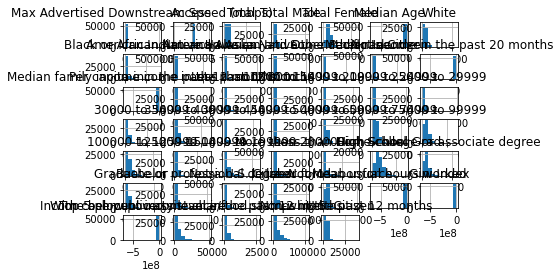

In [ ]:
#Split out blocks without access and analyze
access = non_na[non_na['Access'] == 1]

no_access = non_na[non_na['Access'] == 0]

access.hist()

array([[<AxesSubplot:title={'center':'Max Advertised Downstream Speed (mbps)'}>,
        <AxesSubplot:title={'center':'Access'}>,
        <AxesSubplot:title={'center':'Total'}>,
        <AxesSubplot:title={'center':'Total Male'}>,
        <AxesSubplot:title={'center':'Total Female'}>,
        <AxesSubplot:title={'center':'Median Age'}>,
        <AxesSubplot:title={'center':'White'}>],
       [<AxesSubplot:title={'center':'Black or African American'}>,
        <AxesSubplot:title={'center':'American Indian and Alaska Native'}>,
        <AxesSubplot:title={'center':'Asian'}>,
        <AxesSubplot:title={'center':'Native Hawaiian and Other Pacific Islander'}>,
        <AxesSubplot:title={'center':'Some other race'}>,
        <AxesSubplot:title={'center':'Not a Citizen'}>,
        <AxesSubplot:title={'center':'Median Income in the past 20 months'}>],
       [<AxesSubplot:title={'center':'Median family income in the past 12 months'}>,
        <AxesSubplot:title={'center':'Per capita income i

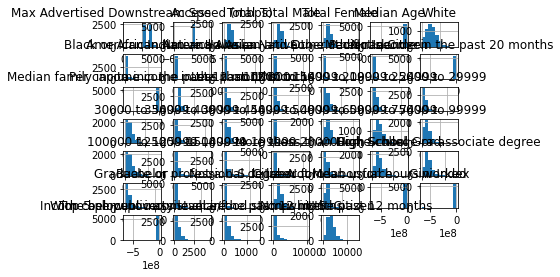

In [ ]:
no_access.hist()